In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
from great_tables import GT, md, html
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline

import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


df = pd.read_csv('data/MIMICtable.csv')
df

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS
0,1,3,7245486000,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6527.000,50.0,13617.0,520.0,-7090.000,5,2
1,2,3,7245500400,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6577.000,50.0,13982.0,365.0,-7405.000,5,2
2,3,3,7245514800,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6627.000,50.0,14262.0,280.0,-7635.000,5,2
3,4,3,7245529200,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6677.000,50.0,14602.0,340.0,-7925.000,5,1
4,5,3,7245543600,0,17639.0,0,0,0,0,1,...,240.000004,0.0,0.0,6727.000,50.0,15142.0,540.0,-8415.000,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266665,8,99995,4612892400,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,6310.0,400.0,-3676.417,0,2
266666,9,99995,4612906800,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,7010.0,700.0,-4376.417,0,2
266667,10,99995,4612921200,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,7430.0,420.0,-4796.417,0,1
266668,11,99995,4612935600,0,8538.0,0,0,0,0,0,...,424.380952,0.0,0.0,2633.583,0.0,7430.0,0.0,-4796.417,4,1


In [192]:
print(df.columns)

print(f'mimic data shape: {df.shape}')

num_icu_stays = len(np.unique(df.icustayid))
print(f'total # of icu stays: {num_icu_stays}')

stays = {} # {3: [1235, 1237, 1238], ...}
for idx, time in zip(df.icustayid, df.charttime):
    stays.setdefault(idx, [])
    stays[idx].append(time)

lens_of_stays = {idx: times[-1] - times[0] for idx, times in stays.items()}

# add column to df
df['time_in_icu'] = df.apply(lambda row: lens_of_stays[row.icustayid], axis=1)

Index(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'died_in_hosp', 'died_within_48h_of_out_time',
       'mortality_90d', 'delay_end_of_record_and_discharge_or_death',
       'Weight_kg', 'GCS', 'HR', 'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2',
       'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN',
       'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT',
       'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'Shock_Index', 'PaO2_FiO2',
       'median_dose_vaso', 'max_dose_vaso', 'input_total', 'input_4hourly',
       'output_total', 'output_4hourly', 'cumulated_balance', 'SOFA', 'SIRS',
       'SOFA_delta', 'Sepsis', 'time_in_icu'],
      dtype='object')
mimic data shape: (266670, 62)
total # of icu stays: 20496


avg # of time points per icu stay: 13.010831381733022


Text(0.5, 0, '# of time points per icu stay')

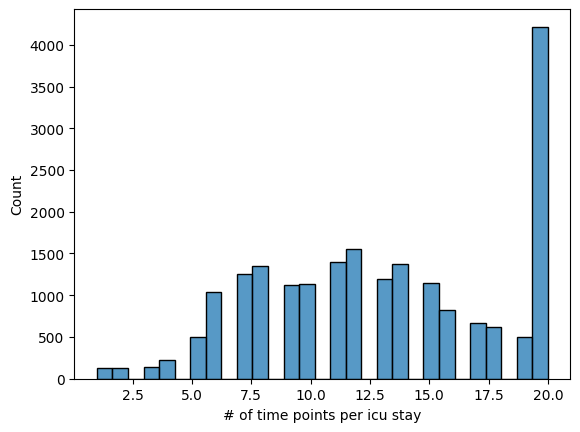

In [73]:
num_time_points_per_stay = [len(times) for times in stays.values()]
print(f'avg # of time points per icu stay: {np.mean(num_time_points_per_stay)}')
sns.histplot(num_time_points_per_stay)
plt.xlabel('# of time points per icu stay')

avg duration of an icu stay (s): 176905.85480093677


Text(0.5, 0, 'duration per icu stay (s)')

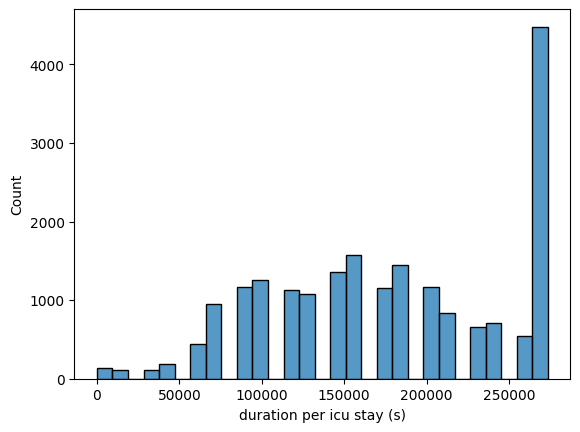

In [74]:
duration_per_stay = [(times[-1] - times[0]) for times in stays.values()]
print(f'avg duration of an icu stay (s): {np.mean(duration_per_stay)}')
sns.histplot(duration_per_stay)
plt.xlabel('duration per icu stay (s)')

In [237]:
# time resolution (delta between time points)

time_deltas = []

last_idx = df.icustayid[0]
last_time = df.charttime[0]
for idx, time in zip(df.icustayid, df.charttime):
    if idx == last_idx:
        time_deltas.append(time - last_time)
    last_idx, last_time = idx, time


pd.Series(time_deltas).value_counts()

14400     242547
28800       2312
43200        855
57600        307
72000        112
86400         31
100800         4
115200         2
0              1
158400         1
129600         1
144000         1
172800         1
Name: count, dtype: int64

In [75]:
# deadality statistics

dead_rate_hosp = np.mean(df.died_in_hosp)
print(f'deadality rate in hospital: {dead_rate_hosp}')

dead_rate_48h = np.mean(df.died_within_48h_of_out_time)
print(f'deadality rate after 48 hours: {dead_rate_48h}') # TODO only among people who leave the hospital alive?

dead_rate_90d = np.mean(df.deadality_90d)
print(f'deadality rate after 90 days: {dead_rate_90d}') # same as above?

mortality rate in hospital: 0.1584467694153823
mortality rate after 48 hours: 0.12189222634717066
mortality rate after 90 days: 0.25541305733678327


In [126]:
# sofa statistics

sofas = {}
for idx, sofa in zip(df.icustayid, df.SOFA):
    sofas.setdefault(idx, [])
    sofas[idx].append(sofa)

sofa_deltas = {idx: (sofa[-1] - sofa[0]) for idx, sofa in sofas.items()}

# apply to df
df['SOFA_delta'] = df.apply(lambda row: sofa_deltas[row.icustayid], axis=1)

In [128]:
# sepsis label

df['Sepsis'] = df.apply(lambda row: 1 if any(sofa >= 2 for sofa in sofas[row.icustayid]) else 0, axis=1)
df['Sepsis'].value_counts()

Sepsis
1    264715
0      1955
Name: count, dtype: int64

avg SOFA of alive patient: 5.361723933570095
avg SOFA of dead patient: 8.825077509289281


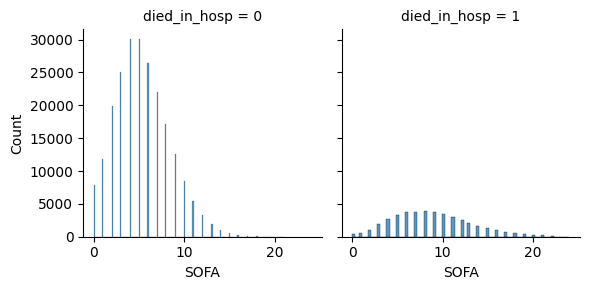

In [120]:
# sofas

avg_sofa_alive = np.mean(df['SOFA'][df['died_in_hosp'] == 0])
print(f'avg SOFA of alive patient: {avg_sofa_alive}')

avg_sofa_dead = np.mean(df['SOFA'][df['died_in_hosp'] == 1])
print(f'avg SOFA of dead patient: {avg_sofa_dead}')

g = sns.FacetGrid(df, col='died_in_hosp')
g.map(sns.histplot, 'SOFA')

avg SOFA delta of alive patient: -1.3226805455914659
avg SOFA delta of dead patient: 0.6613731569356022


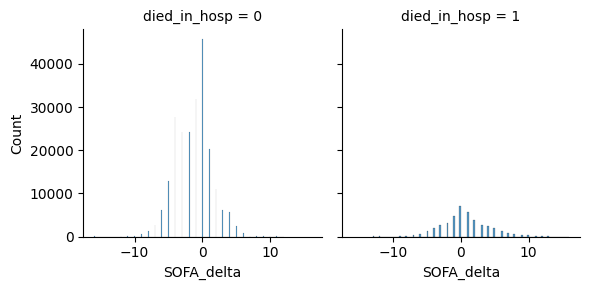

In [119]:
# sofa deltas

avg_sofa_delta_alive = np.mean(df['SOFA_delta'][df['died_in_hosp'] == 0])
print(f'avg SOFA delta of alive patient: {avg_sofa_delta_alive}')

avg_sofa_delta_dead = np.mean(df['SOFA_delta'][df['died_in_hosp'] == 1])
print(f'avg SOFA delta of dead patient: {avg_sofa_delta_dead}')

g = sns.FacetGrid(df, col='died_in_hosp')
g.map(sns.histplot, 'SOFA_delta')

In [215]:
# demographics and outcomes

# limit to those with sepsis
sepsis_df = df[df['Sepsis'] == 1]

# aggregate df
summary = df.groupby('died_in_hosp').agg(
    percent_female = ('gender', lambda x: 100 * (x == 1).mean()),
    mean_age = ('age', 'mean'),
    icu_hours = ('time_in_icu', 'mean'),
    total_population = ('gender', 'count')
)

summary['mean_age'] /= 365 # days -> years
summary['icu_hours'] /= 60*60 # seoncds -> hours

# Rename rows for readability
summary.index = summary.index.map({0: "Survivors", 1: "Non-survivors"})

# Round and format
summary = summary.round({'percent_female': 1, 'mean_age': 1, 'icu_hours': 1})
summary['total_population'] = summary['total_population'].apply(lambda x: f"{x:,}")

# Reorder columns
summary = summary[['percent_female', 'mean_age', 'icu_hours', 'total_population']]
summary.columns = ['% Female', 'Mean Age', 'Hours in ICU', 'Total Population']

print('Summary stats for sepsis patients in ICU:')

# Display
summary

Summary stats for sepsis patients in ICU:


,% Female,Mean Age,Hours in ICU,Total Population
died_in_hosp,,,,
Survivors,44.1,63.9,55.8,"224,417"
Non-survivors,42.8,68.7,62.8,"42,253"


In [163]:
# pca, could be useful for continuous state-space vector

np.random.seed(42)

from sklearn.preprocessing import StandardScaler

state_space_cols = df.columns[3:-11]
X = df[state_space_cols].values

# normalize values in X to prevent the scale from skewing variable importance
X = df[state_space_cols].values
X_scaled = StandardScaler().fit_transform(X)  # mean=0, std=1


pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data={
    'pca_1': pca_result[:, 0],
    'pca_2': pca_result[:, 1],
    'pca_3': pca_result[:, 2],
    'died_in_hosp': df['died_in_hosp'].values,
    'Sepsis': df['Sepsis'].values
})

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.08849077 0.06096936 0.05366207]


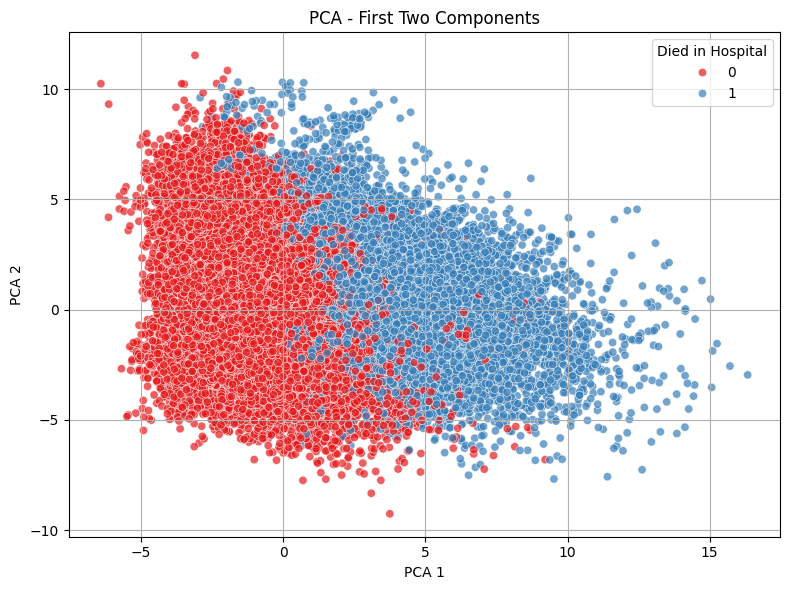

In [168]:
# plot pca in 2d

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue='died_in_hosp',
    palette='Set1',
    data=pca_df,
    alpha=0.7
)
plt.title('PCA - First Two Components')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Died in Hospital')
plt.grid(True)
plt.tight_layout()
plt.show()

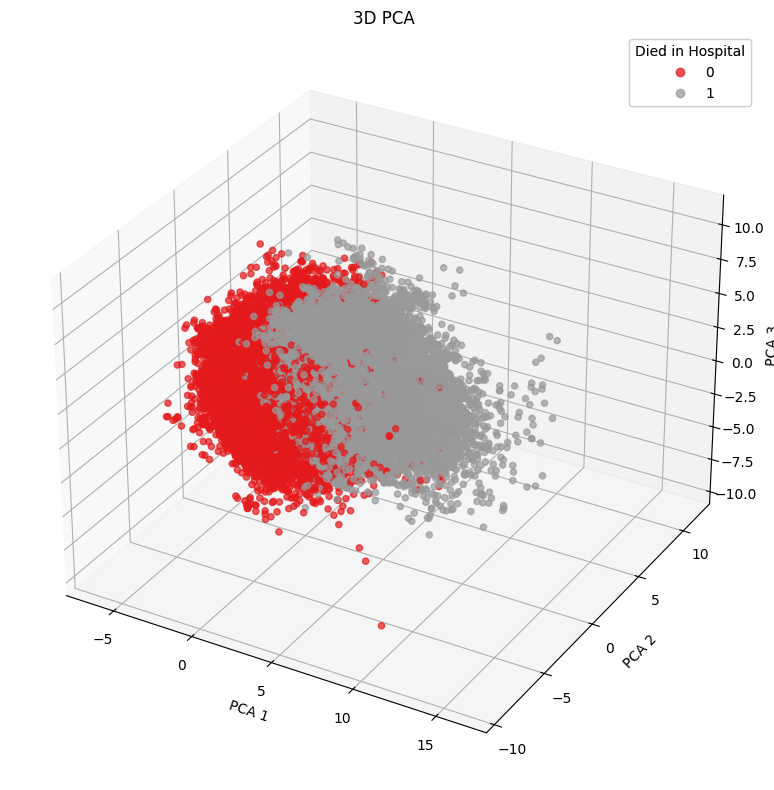

In [162]:
# plot pca in 3d

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_df['pca_1'], pca_df['pca_2'], pca_df['pca_3'],
    c=pca_df['died_in_hosp'], cmap='Set1', alpha=0.7
)
ax.set_title('3D PCA')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
legend1 = ax.legend(*scatter.legend_elements(), title='Died in Hospital')
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

In [ ]:
# t-sne

tsne = TSNE(n_components=2, verbose=0, perplexity=40, max_iter=300)
tsne_result = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data={
    'tsne_1': tsne_result[:, 0],
    'tsne_2': tsne_result[:, 1],
    'died_in_hosp': df['died_in_hosp'].values,
    'Sepsis': df['Sepsis'].values
})

In [187]:
# pca then t-sne


# PCA first to reduce dimensionality

pca_10 = PCA(n_components=10)
#pca_result_30 = pca_30.fit_transform(X_scaled)
pca_result_10 = pca_10.fit_transform(X)

print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))


tsne = TSNE(n_components=2, verbose=0, perplexity=40, max_iter=300)
tsne_result = tsne.fit_transform(pca_result_30)

tsne_df = pd.DataFrame(data={
    'tsne_1': tsne_result[:, 0],
    'tsne_2': tsne_result[:, 1],
    'died_in_hosp': df['died_in_hosp'].values,
    'Sepsis': df['Sepsis'].values
})

Cumulative explained variation for 10 principal components: 0.9999566507498429


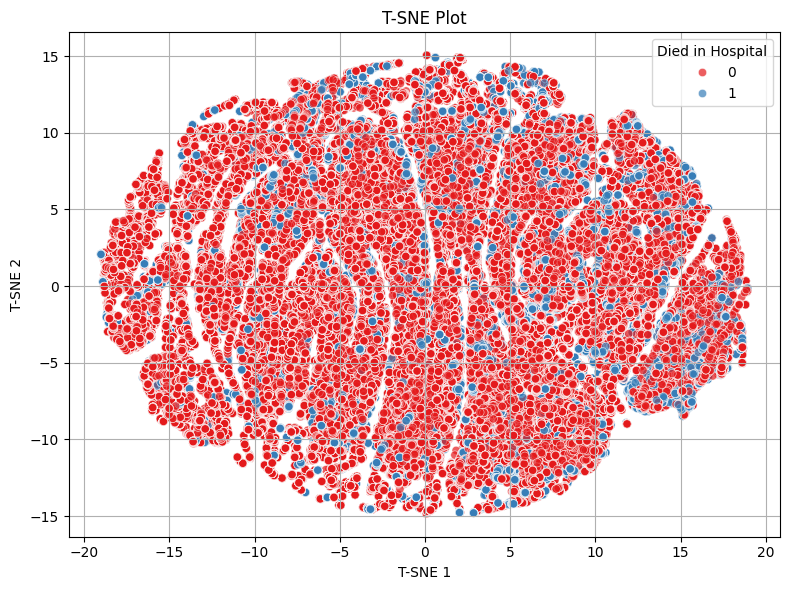

In [190]:
# plot t-sne

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='died_in_hosp',
    palette='Set1',
    data=tsne_df,
    alpha=0.7
)
plt.title('T-SNE Plot')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend(title='Died in Hospital')
plt.grid(True)
plt.tight_layout()
plt.show()